In [2]:
#Google Colab command to see what GPU we've been assigned:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun  7 15:04:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
#Google Colab command to see how much memory we have available at any time:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

#we can enable a high-RAM runtime via Runtime > Change runtime type in the menu.
#Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.



Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
#Connecting to the GDrive
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/CVAI/Task1'
%ls

Mounted at /content/drive
/content/drive/MyDrive/CVAI/Task1
'backup chest_xray'/                     Untitled0.ipynb
 chest_xray/                             Untitled1.ipynb
'Copy of TransferLearningTask.ipynb'     vgg16pneumoniadetection.keras
'inception TransferLearningTask.ipynb'   Xception_pneumoniadetection.keras
 Preparation.ipynb                      'Xception Preparation.ipynb'
 TransferLearningTask.ipynb             'Xception TransferLearningTask.ipynb'


When you import Keras, you don't automatically import everything from keras.layers or other submodules. The main Keras import gives you access to the core functionality, but for specific components, you'll need to import them separately. It's a good practice to import only what you need. This keeps your namespace clean and makes it clear what parts of Keras you're using in your code.

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
import pandas as pd

In [6]:
#Define the image size and paths to the sets
IMAGE_SIZE = [224, 224]
train_path = '/content/drive/MyDrive/CVAI/Task1/chest_xray/p_train/'
valid_path = '/content/drive/MyDrive/CVAI/Task1/chest_xray/p_test/'

1352
normal picture title:  NORMAL2-IM-1285-0001.jpeg
pneumonia picture title: person1244_bacteria_3200.jpeg


Text(0.5, 1.0, 'Pneumonia')

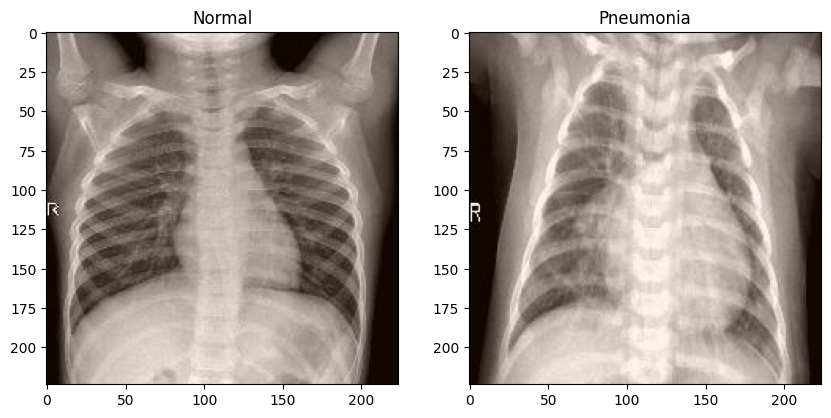

In [7]:
#A look at the data sample images
os.listdir(train_path)
train_n = train_path +'NORMAL/'
train_p = train_path +'PNEUMONIA/'

#An image classified as Normal
print(len(os.listdir(train_n)))
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
print('normal picture title: ',norm_pic)

norm_pic_address = train_n+norm_pic

#An image classified as Pneumonia
rand_p = np.random.randint(0,len(os.listdir(train_p)))

sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic
print('pneumonia picture title:', sic_pic)

# Load the images
norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)

#Show the images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load)
a2.set_title('Pneumonia')

In [8]:
#Loading the pretrained model, excluding the fully-connected (classification) layers at the top of the model.
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#and not retraining already pretrained model again:
for layer in vgg.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [17]:
#We flatten the output of the VGG16 and add our layer(s), the final of which is the prediction.
#In our case the model is binary because we have two classes and use the sigmoid, not softmax, function.

x = Flatten()(vgg.output)
#x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)
#Output layer with binary predictions
prediction = Dense(1, activation='sigmoid')(x)

#Create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
#Compile the Neural network, the model is binary, but it's not necessary to use binary_accuracy, just accuracy would do.
#We use BinaryCrossentropy, though.

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [20]:
#Use the Image Data Generator to import the images from the dataset, normalising them and, in case of train_datagen, augmenting the dataset
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

#We define the paths to the sets, providing the same target size as initialised for the image size, we can change batch size, class mode is binary
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/CVAI/Task1/chest_xray/p_train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

#It's important to turn off shuffle (shuffle=False) here, because by default the function shuffles the output and our predictions won't correspond to the true labels otherwise
validation_set = test_datagen.flow_from_directory('/content/drive/MyDrive/CVAI/Task1/chest_xray/p_val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/CVAI/Task1/chest_xray/p_test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=False)

Found 5235 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [21]:
#Fitting the model

pneumoniamodel = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1904s 12s/step - binary_accuracy: 0.8876 - loss: 0.2858 - val_binary_accuracy: 0.8798 - val_loss: 0.3237
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 402ms/step - binary_accuracy: 0.9547 - loss: 0.1140 - val_binary_accuracy: 0.8942 - val_loss: 0.3133
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 401ms/step - binary_accuracy: 0.9684 - loss: 0.0913 - val_binary_accuracy: 0.9071 - val_loss: 0.2718
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 401ms/step - binary_accuracy: 0.9637 - loss: 0.0961 - val_binary_accuracy: 0.8830 - val_loss: 0.3882
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 400ms/step - binary_accuracy: 0.9703 - loss: 0.0770 - val_binary_accuracy: 0.8702 - val_loss: 0.4761
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 401ms/step - binary_accuracy: 0.9729 - loss: 0.0761 - val_binary_accuracy: 0.9087 - val_loss: 0.3073
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 403ms/step - binary_accuracy: 0.9723 - loss: 0.0773 - val_binary_accuracy: 0.9135 - va

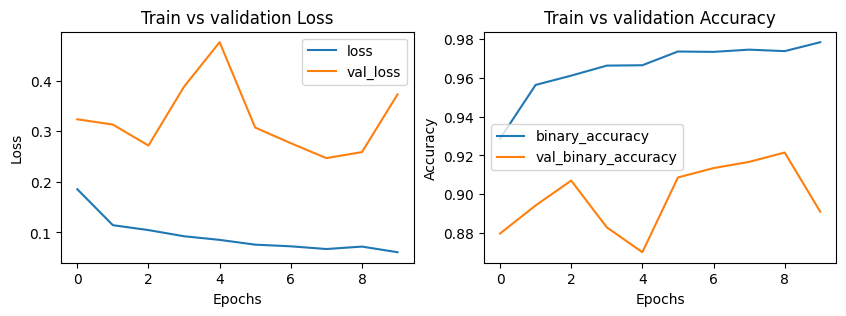

In [22]:
#Plotting the accuracy and validation depending on the epoch

def plot_validation_curves(result):
  result = pd.DataFrame(result)
  fig, axs = plt.subplots(1,2)
  result[['loss','val_loss']].plot(figsize=(10, 3),ax=axs[0])
  axs[0].set_title('Train vs validation Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')
  result[['binary_accuracy','val_binary_accuracy']].plot(figsize=(10, 3),ax=axs[1])
  axs[1].set_title('Train vs validation Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')

plot_validation_curves(pneumoniamodel.history)

In [23]:
#Saving the model
from keras.models import load_model
model.save('vgg16pneumoniadetection.keras')

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step
Class indices mapping: {'NORMAL': 0, 'PNEUMONIA': 1}
Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.97      0.74      0.83       234
   PNEUMONIA       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



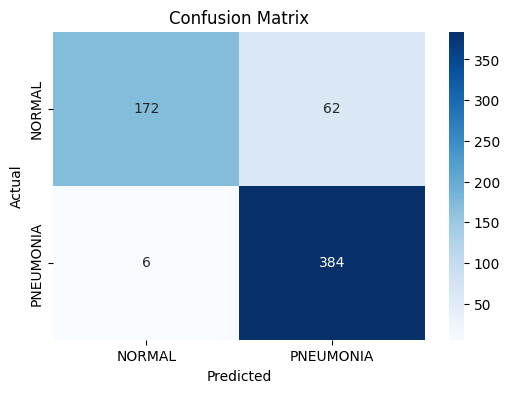

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#Generate predictions (probability scores)
y_pred_probs = model.predict(test_set, steps=len(test_set), verbose=1)

#Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

#True labels (actual labels, as the Data Generator noted them)
true_labels = test_set.classes

#Print class indices mapping
print("Class indices mapping:", test_set.class_indices)

#Confusion matrix
cm = confusion_matrix(true_labels, y_pred)

#Classification report
target_names = list(test_set.class_indices.keys())
report = classification_report(true_labels, y_pred, target_names=target_names, zero_division=0)
print('Classification Report:\n', report)

#Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=target_names,
            yticklabels=target_names,
            cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
Accuracy: 0.81
Precision: 0.73
Recall: 1.00
F1 Score: 0.84
Classification Report:
               precision    recall  f1-score   support

      NORMAL       1.00      0.62      0.77         8
   PNEUMONIA       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


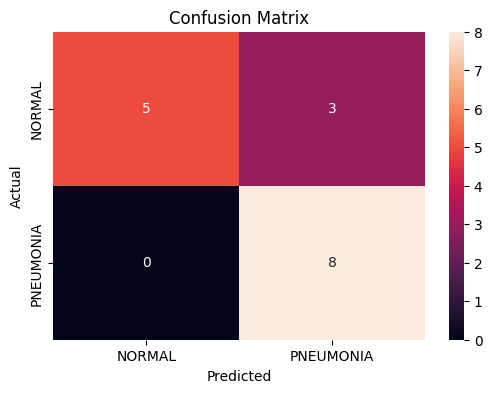

In [25]:
#Let's do the evaluation on the validation set
#Get predicted probabilities
y_pred_probs = model.predict(validation_set, steps=len(test_set), verbose=1)

#Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

true_labels = validation_set.classes

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#Calculating metrics
accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred)
recall = recall_score(true_labels, y_pred)
f1 = f1_score(true_labels, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



#Detailed classification report
report = classification_report(true_labels, y_pred, target_names=list(validation_set.class_indices.keys()), zero_division=0)
print("Classification Report:\n", report)

import matplotlib.pyplot as plt
import seaborn as sns

#Confusion matrix
cm = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(test_set.class_indices.keys()), yticklabels=list(test_set.class_indices.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [26]:
#Let's load the saved model
pneumoniadetection=load_model('/content/drive/MyDrive/CVAI/Task1/vgg16pneumoniadetection.keras')

In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np

#Load the image with target size (must match your model's input size, e.g., 224x224)
img_path = '/content/drive/MyDrive/CVAI/Task1/chest_xray/p_val/NORMAL/NORMAL2-IM-1440-0001.jpeg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))

#Convert image to numpy array
img_array = image.img_to_array(img)

#Expand dimensions to match model input (batch size 1)
img_array = np.expand_dims(img_array, axis=0)

#Normalize the image
img_array /= 255.0


In [28]:
# Run prediction
pred_probs = pneumoniadetection.predict(img_array)
# For binary classification with sigmoid output:
pred_class = (pred_probs > 0.5).astype(int)[0][0]

# For multi-class with softmax, use:
# pred_class = np.argmax(pred_probs, axis=1)[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [29]:
#We have a predicted label/class
predicted_label = pred_class
#Get the class name list ordered by index
class_indices = test_set.class_indices
print(class_indices)
#By default flow_from_directory orders classes in alphabet order, so neutral is 0 and pneumonia is 1 as we wish,
#but just in case we create and show an ordered list of class names
class_list = [k for k, v in sorted(class_indices.items(), key=lambda item: item[1])]
#Find the class name for the predicted label
predicted_class_name = class_list[predicted_label]

print(f"Predicted class: {predicted_class_name}")

{'NORMAL': 0, 'PNEUMONIA': 1}
Predicted class: NORMAL


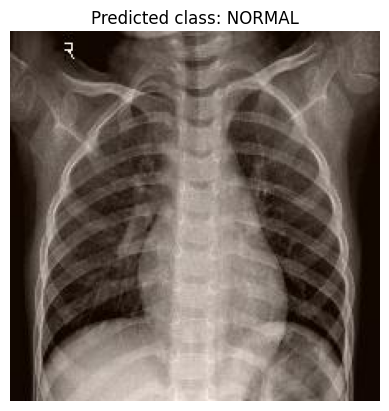

In [30]:
#And let's show the image
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted class: {predicted_class_name}")
plt.show()